In [52]:
import pandas as pd
import re
from string import punctuation as punct

from bs4 import BeautifulSoup

import spacy

from gensim import*

import matplotlib.pyplot as plt

import numpy as np

from string import punctuation as punct

from collections import Counter

from gensim.models import Phrases

from gensim.models.coherencemodel import CoherenceModel

import matplotlib.pyplot as plt

import time

from gensim.models.ldamodel import LdaModel

### Data Injection: 
Import all the 9 `csv`files containing the extracted nairaland.com posts and concatenate them into a single df.

In [53]:
#glob allows reading of multiple files with similar partern(e.g '.csv') from the same path
import glob 
path = 'capstone4_nairaland_canada_spider'
#create file paths
full_paths = glob.glob(path + "/*.csv") 

In [54]:
data_raw_orig = pd.DataFrame()
for file in full_paths:
    df = pd.read_csv(file)
    data_raw_orig = data_raw_orig.append(df,ignore_index=True)
    
data_raw_orig.head()

,scraped_comment,time,date,year
0,"<div class=""narrow""><blockquote><b>solomonwis:</b> <br><br>Did you get this “fact” from the link...",8:13pm,May 16,2013
1,"<div class=""narrow""><blockquote><b>solomonwis:</b> <br><br>CORRECT!</blockquote><br>This means I...",8:15pm,May 16,2013
2,"<div class=""narrow"">Once again I copy n paste<br>Selection FactorMaximum points<br>English and/o...",8:18pm,May 16,2013
3,"<div class=""narrow"">[/quote]<blockquote><b>solomonwis:</b> <br><br>Did you get this “fact” from ...",8:19pm,May 16,2013
4,"<div class=""narrow""><blockquote><b>solomongrandy:</b> <br><br>I want it too LadyGuinivere and yo...",9:13pm,May 16,2013


**Data dimension**

In [55]:
data_raw_orig.shape

(133786, 4)

In [56]:
data_raw = data_raw_orig

# Text Cleaning

### Create a seperate coloumn for quoted comments attached to the main posts.  
Some of the posters quoted the users they were reponding to. I will seperate all quoted texts from posts to avoid repitition and create another column for them. 

In [57]:
# create a new column for for quoted post
def get_quotes(post):
    if '<blockquote>' in post:
        return BeautifulSoup(post).find('blockquote').text
    else:
        return ''

data_raw['quotes'] = data_raw.scraped_comment.apply(lambda x: get_quotes(x)).copy()


### Remove quoted comments and clean up texts in post

In [58]:
#code up function for text cleaning
chars = ['<br>', '[\[].*?[\]]', '<blockquote>(.*?)</blockquote>', '•', '–', '�'] #replace newline tags, text in square brackets, text in blockquote, and '•' 
def clean_text(post):
    global post_text
    global post_text_clean
    for char in chars:
        #replace all char with ' ' 
        post = re.sub(char, ' ', post)
        
    #obtain text of the post without any quotation tags    
    if '<div' in post:
        post_text = BeautifulSoup(post).find('div').text
        # Remove newlines and other extra whitespace by splitting and rejoining.
        post_text_clean = ' '.join(post_text.split())
        
    #get the list of all punctuations from regex library 
    punctuation = re.compile('[{}]+'.format(re.escape(punct)))
    #remove all punctuations
    post_text_clean = punctuation.sub('', post_text_clean)
    post_text_clean = ' '.join(post_text_clean.split())
    #conver all characters to lower case
    post_text_clean = post_text_clean.lower()
    return post_text, post_text_clean

<>:2: DeprecationWarning: invalid escape sequence \[
<>:2: DeprecationWarning: invalid escape sequence \[
<>:2: DeprecationWarning: invalid escape sequence \[
<ipython-input-58-23d5c1b10acd>:2: DeprecationWarning: invalid escape sequence \[
  chars = ['<br>', '[\[].*?[\]]', '<blockquote>(.*?)</blockquote>', '•', '–', '�'] #replace newline tags, text in square brackets, text in blockquote, and '•'


In [59]:
#create column to store the main text from post - with sligth cleaning
data_raw['raw_post_text'] = data_raw['scraped_comment'].apply(lambda x: clean_text(x)[0]).copy()

#create column to store the cleaned main text from post - clean enough for modelling
data_raw['cleaned_post'] = data_raw['scraped_comment'].apply(lambda x: clean_text(x)[1]).copy()
data_raw.head()

,scraped_comment,time,date,year,quotes,raw_post_text,cleaned_post
0,"<div class=""narrow""><blockquote><b>solomonwis:</b> <br><br>Did you get this “fact” from the link...",8:13pm,May 16,2013,solomonwis: Did you get this “fact” from the link or that's what you think?You really need to re...,Waow waow waow!!! Solomonwis is SOOOOOOOOOOO correct. I just took a second glance at it. I wil...,waow waow waow solomonwis is sooooooooooo correct i just took a second glance at it i will expla...
1,"<div class=""narrow""><blockquote><b>solomonwis:</b> <br><br>CORRECT!</blockquote><br>This means I...",8:15pm,May 16,2013,solomonwis: CORRECT!,This means I will be getting 28points for language. So good to know.,this means i will be getting 28points for language so good to know
2,"<div class=""narrow"">Once again I copy n paste<br>Selection FactorMaximum points<br>English and/o...",8:18pm,May 16,2013,,Once again I copy n paste Selection FactorMaximum points English and/or French skills 28 Educati...,once again i copy n paste selection factormaximum points english andor french skills 28 educatio...
3,"<div class=""narrow"">[/quote]<blockquote><b>solomonwis:</b> <br><br>Did you get this “fact” from ...",8:19pm,May 16,2013,solomonwis: Did you get this “fact” from the link or that's what you think?You really need to re...,"I agree with you.Because you get the 4 extra points from your score in IELTS, as stated ( IELT...",i agree with youbecause you get the 4 extra points from your score in ielts as stated ielts is a...
4,"<div class=""narrow""><blockquote><b>solomongrandy:</b> <br><br>I want it too LadyGuinivere and yo...",9:13pm,May 16,2013,solomongrandy: I want it too LadyGuinivere and yours when you get his....lol,,


**Filter out empty posts(i.e posts with just quote or even with not quote as well) and re-index the df.**

In [62]:
#filter out empty posts, i.e posts with just quote or even with not quote as well
data_prepared = data_raw[data_raw['cleaned_post'] != ''].reset_index(drop=True)

In [177]:
data_prepared.head()

,scraped_comment,time,date,year,quotes,raw_post_text,cleaned_post
0,"<div class=""narrow""><blockquote><b>solomonwis:</b> <br><br>Did you get this “fact” from the link...",8:13pm,May 16,2013,solomonwis: Did you get this “fact” from the link or that's what you think?You really need to re...,Waow waow waow!!! Solomonwis is SOOOOOOOOOOO correct. I just took a second glance at it. I wil...,waow waow waow solomonwis is sooooooooooo correct i just took a second glance at it i will expla...
1,"<div class=""narrow""><blockquote><b>solomonwis:</b> <br><br>CORRECT!</blockquote><br>This means I...",8:15pm,May 16,2013,solomonwis: CORRECT!,This means I will be getting 28points for language. So good to know.,this means i will be getting 28points for language so good to know
2,"<div class=""narrow"">Once again I copy n paste<br>Selection FactorMaximum points<br>English and/o...",8:18pm,May 16,2013,,Once again I copy n paste Selection FactorMaximum points English and/or French skills 28 Educati...,once again i copy n paste selection factormaximum points english andor french skills 28 educatio...
3,"<div class=""narrow"">[/quote]<blockquote><b>solomonwis:</b> <br><br>Did you get this “fact” from ...",8:19pm,May 16,2013,solomonwis: Did you get this “fact” from the link or that's what you think?You really need to re...,"I agree with you.Because you get the 4 extra points from your score in IELTS, as stated ( IELT...",i agree with youbecause you get the 4 extra points from your score in ielts as stated ielts is a...
4,"<div class=""narrow""><blockquote><b>mpi210:</b> <br><br>@Solomonwis,<br><br>Please which address ...",8:49am,May 17,2013,"mpi210: @Solomonwis,Please which address can we send the completed application forms since they ...","Centralized Intake Office Federal Skilled Worker (FSW) P.O. BOX 7500 Sydney, NS B1P 0A9 Canada",centralized intake office federal skilled worker fsw po box 7500 sydney ns b1p 0a9 canada


In [64]:
#number of empty posts deleted
data_raw.shape[0] - data_prepared.shape[0]

5858

In [65]:
#print out a sample post pre and post cleaning
print(data_prepared.scraped_comment[0])
print('----------------------------------------------------------')
print(data_prepared.quotes[0])
print('----------------------------------------------------------')
print(data_prepared.raw_post_text[0])
print('----------------------------------------------------------')
print(data_prepared.cleaned_post[0])
print('----------------------------------------------------------')


<div class="narrow"><blockquote><b>solomonwis:</b> <br><br>Did you get this “fact” from the link or that's what you think?<br><br>You really need to read that link before you confuse people!<br><br>You get the four (4) extra points when you meet the minimum threshold in your first language {First Language can either be English or French}.<br></blockquote><br>Waow waow waow!!! Solomonwis is SOOOOOOOOOOO correct. I just took a second glance at it. I will explain it better though. <br> <br> Speaking        Reading         Listening       Writing<br><br>7.0 – 9.0 	8.0 – 9.0 	7.0 – 9.0 	7.0 – 9.0<br><br>If your scores fall into this range for each of them, then you get an additional 4point GBAM!!!</div>
----------------------------------------------------------
solomonwis: Did you get this “fact” from the link or that's what you think?You really need to read that link before you confuse people!You get the four (4) extra points when you meet the minimum threshold in your first language {Firs

# Slizing out the cleaned posts from the data frame to create a corpus for modelling

In [66]:
text_corpus = data_prepared.cleaned_post
text_corpus[:6]

0    waow waow waow solomonwis is sooooooooooo correct i just took a second glance at it i will expla...
1                                     this means i will be getting 28points for language so good to know
2    once again i copy n paste selection factormaximum points english andor french skills 28 educatio...
3    i agree with youbecause you get the 4 extra points from your score in ielts as stated ielts is a...
4              centralized intake office federal skilled worker fsw po box 7500 sydney ns b1p 0a9 canada
5                courier address centralized intake office 49 dorchester street sydney ns b1p 5z2 canada
Name: cleaned_post, dtype: object

# Text Processing in Spacy
https://nlpforhackers.io/complete-guide-to-spacy/

In [67]:
nlp = spacy.load('en')

In [68]:
# Parse each post to wrap it in as a spacy object.
corpus_spacy = [nlp(x) for x in text_corpus]

In [69]:
# lemmatize, take out stop words and puctuation from each post. Lastly remove all numbers but retain words with numbers
corpus_processed = [] 
for nlp_text in corpus_spacy:
    clean_text_processed = [
        token.lemma_.lower()
        for token in nlp_text
        if not token.is_stop
        and not token.is_punct
        and not token.is_digit
    ]
    corpus_processed.append(clean_text_processed)

In [70]:
corpus_processed[0]

['waow',
 'waow',
 'waow',
 'solomonwis',
 'sooooooooooo',
 'correct',
 'take',
 'second',
 'glance',
 'explain',
 'better',
 'speak',
 'reading',
 'listen',
 'write',
 'score',
 'fall',
 'range',
 'additional',
 '4point',
 'gbam']

# Create Bigrams and Trigrams and add to Documents

In [71]:
#creat bigram and trigram corpus. Here n_grams will only be applied to words that appear in up to 200 docs
bigram = Phrases(corpus_processed, min_count=200)
trigram = Phrases(bigram[corpus_processed])

In [72]:
for i in range(len(corpus_processed)): #for each doc
    for token in bigram[corpus_processed[i]]: #create bigram for the particular doc
        if '_' in token: # Token is a bigram, add to the particular doc document.
            corpus_processed[i].append(token)
    for token in trigram[corpus_processed[i]]: #create trigram for the particular doc
        if '_' in token: # Token is a bigram, add to document.
            corpus_processed[i].append(token)

In [73]:
#let's see what a document now looks like
corpus_processed[50]

['like',
 'suggest',
 'people',
 'follow',
 'timeline',
 'record',
 'progress',
 'application',
 'encourage',
 'interested',
 'move',
 'permanently',
 'canada',
 'user',
 'nationality',
 'app',
 'file',
 'local',
 'canadian',
 'visa',
 'office',
 'local',
 'canadian',
 'visa',
 'office',
 'aor',
 'receive',
 'date',
 'ielt',
 'exam',
 'date',
 'ielt',
 'exam',
 'score',
 'skill',
 'test',
 'r',
 'w',
 'l',
 's',
 'ielt',
 'aggregate',
 'score',
 'high',
 'degree',
 'work',
 'experience',
 'year',
 'job',
 'offer',
 'canada',
 'yesno',
 'file',
 'transfer',
 'local',
 'consulate',
 'initial',
 'assessment',
 'receive',
 'document',
 'request',
 'document',
 'send',
 'medical',
 'request',
 'medical',
 'medical',
 'send',
 'interview',
 'waive',
 'yesno',
 'interview',
 'date',
 'passport',
 'request',
 'application',
 'statusapprovedpendingdismiss',
 'approvaldenial',
 'date',
 'passport',
 'receive',
 'date',
 'land',
 'canada',
 'land',
 'city',
 'total',
 'processing',
 'time',
 'day

# Create a corpus Dictionary and set word frequency thresholds
_Reference: https://radimrehurek.com/gensim/tut1.html_, https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/, #https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [74]:
#create corpus dictionary
corpus_dictionary = corpora.Dictionary(corpus_processed)
print(corpus_dictionary)

Dictionary(68884 unique tokens: ['4point', 'additional', 'better', 'correct', 'explain']...)


In [75]:
#create threshold for word frequencies
corpus_dictionary.filter_extremes(no_below=100, no_above=0.3, keep_n=None, keep_tokens=None)

In [76]:
#visualize tokens and their token ids in the dictionary
dic_viz = corpus_dictionary.token2id
dic_viz

{'additional': 0,
 'better': 1,
 'correct': 2,
 'explain': 3,
 'fall': 4,
 'listen': 5,
 'range': 6,
 'reading': 7,
 'score': 8,
 'second': 9,
 'speak': 10,
 'take': 11,
 'write': 12,
 'get': 13,
 'good': 14,
 'know': 15,
 'language': 16,
 'mean': 17,
 'adaptability': 18,
 'age': 19,
 'andor': 20,
 'arrange': 21,
 'canada': 22,
 'copy': 23,
 'education': 24,
 'employment': 25,
 'english': 26,
 'experience': 27,
 'french': 28,
 'mark': 29,
 'n': 30,
 'pass': 31,
 'point': 32,
 'selection': 33,
 'skill': 34,
 'total': 35,
 'agree': 36,
 'extra': 37,
 'extra_point': 38,
 'ielt': 39,
 'state': 40,
 'test': 41,
 'box': 42,
 'federal': 43,
 'federal_skilled': 44,
 'fsw': 45,
 'intake': 46,
 'office': 47,
 'skilled': 48,
 'sydney': 49,
 'worker': 50,
 'address': 51,
 'courier': 52,
 'street': 53,
 'alagbon': 54,
 'big': 55,
 'certificate': 56,
 'department': 57,
 'depend': 58,
 'finger': 59,
 'hour': 60,
 'maximum': 61,
 'pay': 62,
 'police': 63,
 'power': 64,
 'print': 65,
 'ready': 66,
 'wa

In [77]:
#visualize token ids and their document frequencies
doc_freq = corpus_dictionary.dfs
doc_freq

{2: 1095,
 11: 2811,
 9: 972,
 3: 1385,
 1: 640,
 10: 1296,
 7: 482,
 5: 932,
 12: 4790,
 8: 5320,
 4: 4186,
 6: 180,
 0: 1738,
 17: 4287,
 13: 9574,
 16: 625,
 14: 15422,
 15: 10364,
 23: 1801,
 30: 529,
 33: 112,
 32: 5488,
 26: 615,
 20: 139,
 28: 409,
 34: 565,
 24: 2327,
 27: 5186,
 19: 1313,
 21: 219,
 25: 1092,
 22: 6335,
 18: 109,
 35: 1302,
 31: 2459,
 29: 682,
 36: 522,
 37: 668,
 39: 9147,
 40: 2575,
 41: 2207,
 38: 155,
 46: 145,
 47: 2347,
 43: 512,
 48: 650,
 50: 528,
 45: 712,
 42: 221,
 49: 211,
 44: 265,
 52: 1052,
 51: 2024,
 53: 101,
 59: 351,
 65: 722,
 67: 215,
 57: 221,
 54: 191,
 60: 650,
 61: 463,
 62: 3998,
 58: 728,
 55: 1754,
 64: 167,
 63: 729,
 56: 5761,
 66: 1483,
 82: 5709,
 80: 1521,
 71: 777,
 68: 111,
 70: 7083,
 76: 21979,
 78: 243,
 83: 5161,
 81: 210,
 74: 1885,
 75: 669,
 72: 6012,
 73: 1007,
 79: 3157,
 77: 430,
 69: 164,
 91: 1581,
 89: 4173,
 84: 557,
 86: 546,
 88: 732,
 90: 14799,
 92: 1520,
 87: 1729,
 85: 448,
 93: 389,
 95: 2562,
 94: 669,


In [78]:
#generate the whole token ids in the corpus dictionary, not ordered
token_ids = doc_freq.keys()

#generate the document freq of each word(same order as id above), then sort in descending order
token_freq_in_docs = sorted(doc_freq.values(), reverse=True)

#frequency of the top ten frequent words accross all documents
token_freq_in_docs[:10]

[27327, 21979, 15422, 14799, 10469, 10366, 10364, 9574, 9147, 8854]

In [79]:
#print corpus statistics
print('Number of unique tokens: %d' % len(corpus_dictionary))
print('Number of documents: %d' % len(corpus_processed))

Number of unique tokens: 2335
Number of documents: 127928


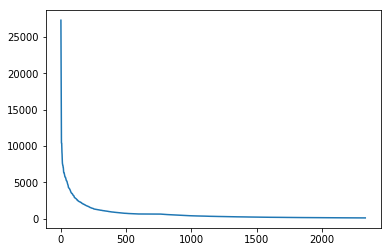

In [80]:
#plot of token's doc freq 
plt.plot(token_freq_in_docs)

plt.show()

#sorted_token_fre

#sorted_token_fre[3650]

In [81]:
#the most porpular word accross documents(posts)
corpus_dictionary[sorted(corpus_dictionary.dfs.items(), key=lambda x: x[1], reverse=True)[0][0]]

'thank'

In [82]:
#top 10 most popular words indictionary
for i in range(10):
    print(corpus_dictionary[sorted(corpus_dictionary.dfs.items(), key=lambda x: x[1], reverse=True)[i][0]])

thank
not
good
need
send
ppr
know
get
ielt
wes


# Generate `BoW` from the  `corpus_dictionary` 
This will be generated using the `corpus_dictionary`above. It will look at each word in each document, return the `id` of the word and how many times the word appears in the document as a turple. Since the dictionary was created from the combination of the same documents, a turple is returned for every word in each document. If for example I run the `doc2bow` through an alien string of 5 words out of which only 3 is contained in the dictionary, only 3 turples will be returned. 

First I will run a test on the `dictionary` before running the whole documents through it:

In [83]:
#using the dictionary on an alien string
alien = 'valency is the removal of an electron from the outermost shell of an atom, thank you'.split()
print(corpus_dictionary.doc2bow(alien))
print()

#now let's see how this works out on one of our documents
print(corpus_processed[200])
print()
print(corpus_dictionary.doc2bow(corpus_processed[200]))

[(160, 1)]

['like', 'say', 'base', 'personal', 'experiencei', 'app', 'reject', 'd', '1st', 'time', 'sum', 'correction', 'attach', 'itwork', 'd', 'correction', 'resent', 'get', 'accept', 'favour', 'd', 'correction', 'attach', 'app', 'cos', 'everybody', 'get', 'favour', 'correction_attach', 'correction_attach']

[(13, 2), (113, 1), (130, 1), (138, 2), (147, 1), (148, 3), (156, 1), (190, 1), (222, 1), (331, 2), (401, 1), (693, 1), (820, 2), (855, 1), (901, 3), (1005, 1), (1006, 1)]


**Only `thank`with id 160 appeared in our dictionary from the alien string and it only appeared once. Meanwhile, all the words in document 200 appeared as expected since it was part of the documents we generated the dictionary with. Lets print and see the words in this document below:**

In [84]:
print([corpus_dictionary.id2token[x[0]] for x in corpus_dictionary.doc2bow(corpus_processed[200])])

['get', 'like', 'accept', 'attach', 'cos', 'd', 'time', 'base', 'say', 'app', 'reject', '1st', 'favour', 'personal', 'correction', 'everybody', 'sum']


**Now I will create a BoW using the whole `133,786` of the document**

In [85]:
corpus_BoW = [corpus_dictionary.doc2bow(item) for item in corpus_processed]
corpus_BoW_df = pd.DataFrame(corpus_BoW)
corpus_BoW_df.head()

,0,1,2,3,4,5,6,7,8,9,...,518,519,520,521,522,523,524,525,526,527
0,"(0, 1)","(1, 1)","(2, 1)","(3, 1)","(4, 1)","(5, 1)","(6, 1)","(7, 1)","(8, 1)","(9, 1)",...,None,None,None,None,None,None,None,None,None,None
1,"(13, 1)","(14, 1)","(15, 1)","(16, 1)","(17, 1)",None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,"(18, 1)","(19, 1)","(20, 1)","(21, 1)","(22, 1)","(23, 1)","(24, 1)","(25, 1)","(26, 1)","(27, 1)",...,None,None,None,None,None,None,None,None,None,None
3,"(8, 1)","(16, 1)","(26, 1)","(32, 1)","(36, 1)","(37, 1)","(38, 1)","(39, 2)","(40, 1)","(41, 1)",...,None,None,None,None,None,None,None,None,None,None
4,"(22, 1)","(42, 1)","(43, 1)","(44, 3)","(45, 1)","(46, 1)","(47, 1)","(48, 1)","(49, 1)","(50, 1)",...,None,None,None,None,None,None,None,None,None,None


**Now I have the two important elements required to implement LDA: BoW from `corpus dictionary` and `id2word`. I will now implement the LDA using below initial hyper parameters.**

# Set n-topics and run LDA
Now the statge is set to run the LDA model using the BoW and the dictinary

In [86]:
# Set parameters.
num_topics = 5
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = corpus_dictionary[0]  # only to "load" the dictionary.
id2word = corpus_dictionary.id2token

lda_model = LdaModel(corpus=corpus_BoW, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(0, '0.047*"god_bless" + 0.039*"god" + 0.037*"reference_letter" + 0.034*"will_not" + 0.023*"will" + 0.023*"thread" + 0.020*"thank" + 0.019*"bless" + 0.015*"letter" + 0.015*"page"'), (1, '0.025*"not" + 0.020*"thank" + 0.013*"need" + 0.013*"get" + 0.011*"send" + 0.010*"good" + 0.010*"know" + 0.009*"wes" + 0.008*"write" + 0.008*"time"'), (2, '0.035*"express_entry" + 0.024*"hello" + 0.023*"good_morning" + 0.022*"visa" + 0.019*"congratulation" + 0.019*"profile" + 0.017*"enter_pool" + 0.015*"link" + 0.014*"entry" + 0.014*"morning"'), (3, '0.043*"ppr" + 0.039*"congratulation" + 0.026*"congrat" + 0.025*"ita" + 0.024*"end_praise" + 0.017*"account" + 0.015*"gift_deed" + 0.014*"god" + 0.014*"aor" + 0.013*"wait"'), (4, '0.064*"work" + 0.057*"work_experience" + 0.038*"score" + 0.038*"experience" + 0.030*"year" + 0.024*"point" + 0.022*"job" + 0.019*"crs_score" + 0.017*"noc" + 0.016*"amen"')]


# Model evaluation: Topic Coherence

### Using c_v Measure
Alternatively, I can use U-mass measure to calculate coeherence

In [87]:
# Compute Coherence Score using c_v
coherence_lda_model = CoherenceModel(model=lda_model, texts=corpus_processed, dictionary=corpus_dictionary, coherence='c_v')
coherence_lda = coherence_lda_model.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.48084468361277716


# Searching for the Optimum Number of Topics Based on c_v Scores
Running this search, I will leave all other hyper parameters of the LDA models as default except the n_topics.

In [88]:
#create list to collect cv values
coherence_values = []
#create list to collect each model list
model_list = []
for num_topics in range(5, 40, 5):
    start_time = time.time()
    model=LdaModel(corpus=corpus_BoW, id2word=corpus_dictionary, num_topics=num_topics)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=corpus_processed, dictionary=corpus_dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

In [89]:
pd.set_option('display.max_colwidth', -1)
pd.DataFrame({'No. of Topics': range(5, 40, 5), 'Coherence Values':coherence_values, 'Model Details':model_list})

,No. of Topics,Coherence Values,Model Details
0,5,0.518390,"LdaModel(num_terms=2335, num_topics=5, decay=0.5, chunksize=2000)"
1,10,0.549096,"LdaModel(num_terms=2335, num_topics=10, decay=0.5, chunksize=2000)"
2,15,0.530964,"LdaModel(num_terms=2335, num_topics=15, decay=0.5, chunksize=2000)"
3,20,0.518380,"LdaModel(num_terms=2335, num_topics=20, decay=0.5, chunksize=2000)"
4,25,0.493365,"LdaModel(num_terms=2335, num_topics=25, decay=0.5, chunksize=2000)"
5,30,0.477307,"LdaModel(num_terms=2335, num_topics=30, decay=0.5, chunksize=2000)"
6,35,0.465165,"LdaModel(num_terms=2335, num_topics=35, decay=0.5, chunksize=2000)"


### Plot of n_topic gainst topic coherence scores

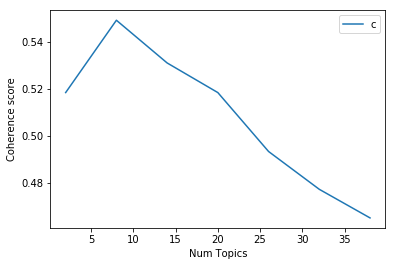

In [90]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

**As can be seen above, the optimum number of topics for this corpus is 10. This is in conformity with my initial assumption considering the categories of issues being discussed in the forum. Now will re-run the tunned model with `n_topic` of `10`.**

# Run LDA model again with `n_topic` of 10

In [91]:
# Set parameters.
num_topics = 10
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = corpus_dictionary[0]  # only to "load" the dictionary.
id2word = corpus_dictionary.id2token

lda_model = LdaModel(corpus=corpus_BoW, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(0, '0.081*"work" + 0.072*"work_experience" + 0.063*"year" + 0.061*"letter" + 0.060*"reference_letter" + 0.048*"experience" + 0.032*"job" + 0.028*"reference" + 0.022*"noc" + 0.018*"bsc"'), (1, '0.026*"submit" + 0.023*"new" + 0.020*"passport" + 0.020*"application" + 0.019*"need" + 0.019*"page" + 0.016*"family" + 0.016*"document" + 0.016*"aor" + 0.016*"change"'), (2, '0.040*"not" + 0.026*"good" + 0.024*"congratulation" + 0.021*"get" + 0.021*"ppr" + 0.018*"know" + 0.016*"time" + 0.014*"be" + 0.014*"like" + 0.014*"come"'), (3, '0.080*"ielt" + 0.059*"write" + 0.053*"score" + 0.038*"u" + 0.029*"exam" + 0.025*"test" + 0.023*"je_mappelle" + 0.022*"crs_score" + 0.021*"na" + 0.021*"point"'), (4, '0.065*"account" + 0.056*"gift_deed" + 0.046*"pof" + 0.046*"bank" + 0.043*"statement" + 0.034*"wow" + 0.031*"fund" + 0.027*"gift" + 0.026*"draw" + 0.024*"ok"'), (5, '0.289*"thank" + 0.053*"pls" + 0.053*"thread" + 0.040*"hello" + 0.030*"house" + 0.029*"appreciate" + 0.028*"response" + 0.025*"remark" + 0.

# Model Visualization using the interractive PYLDAviz library

In [92]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus_BoW, dictionary=corpus_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.064466  0.190740  1       1        27.749161
8     -0.206189  0.027200  2       1        14.100859
1     -0.166498 -0.054963  3       1        13.222443
9     -0.206895  0.035825  4       1        11.471995
3      0.057078 -0.316454  5       1        6.523060 
0     -0.138312 -0.084046  6       1        6.258480 
5      0.211852  0.146988  7       1        6.086118 
7      0.193988  0.095738  8       1        5.233591 
4      0.103657  0.162806  9       1        4.688795 
6      0.215785 -0.203833  10      1        4.665504 , topic_info=     Category          Freq              Term         Total  loglift  logprob
term                                                                         
160   Default  37721.000000  thank             37721.000000  30.0000  30.0000
2037  Default  20585.000000  ita               20585.000000  29.0000  29.0000
803   Default  17291.000000  god               17291.000000  28.0000  28.0000
1117  Default  14055.000000  god_bless         14055.000000  27.0000  27.0000
1811  Default  12604.000000  express_entry     12604.000000  26.0000  26.0000
136   Default  10888.000000  work              10888.000000  25.0000  25.0000
39    Default  11935.000000  ielt              11935.000000  24.0000  24.0000
159   Default  13054.000000  send              13054.000000  23.0000  23.0000
364   Default  9670.000000   work_experience   9670.000000   22.0000  22.0000
187   Default  8435.000000   year              8435.000000   21.0000  21.0000
398   Default  8153.000000   letter            8153.000000   20.0000  20.0000
452   Default  10326.000000  wes               10326.000000  19.0000  19.0000
1231  Default  7988.000000   reference_letter  7988.000000   18.0000  18.0000
12    Default  8897.000000   write             8897.000000   17.0000  17.0000
76    Default  27085.000000  not               27085.000000  16.0000  16.0000
8     Default  7362.000000   score             7362.000000   15.0000  15.0000
131   Default  6512.000000   account           6512.000000   14.0000  14.0000
472   Default  6895.000000   pls               6895.000000   13.0000  13.0000
129   Default  7227.000000   thread            7227.000000   12.0000  12.0000
2042  Default  6049.000000   enter_pool        6049.000000   11.0000  11.0000
1476  Default  14080.000000  congratulation    14080.000000  10.0000  10.0000
27    Default  6475.000000   experience        6475.000000   9.0000   9.0000 
14    Default  15842.000000  good              15842.000000  8.0000   8.0000 
2122  Default  5646.000000   gift_deed         5646.000000   7.0000   7.0000 
1116  Default  5747.000000   bless             5747.000000   6.0000   6.0000 
2004  Default  12604.000000  ppr               12604.000000  5.0000   5.0000 
297   Default  7286.000000   eca               7286.000000   4.0000   4.0000 
1625  Default  4896.000000   pool              4896.000000   3.0000   3.0000 
1237  Default  4818.000000   express           4818.000000   2.0000   2.0000 
56    Default  8222.000000   certificate       8222.000000   1.0000   1.0000 
...       ...          ...       ...                   ...      ...      ... 
2042  Topic10  6048.314453   enter_pool        6049.334961   3.0648  -2.8049 
1625  Topic10  4895.044434   pool              4896.064941   3.0648  -3.0164 
1237  Topic10  4817.066895   express           4818.087402   3.0648  -3.0325 
1610  Topic10  4470.942383   husband           4471.962891   3.0647  -3.1071 
1999  Topic10  4331.089844   raise_cse         4332.110352   3.0647  -3.1388 
826   Topic10  4105.701172   email_address     4106.721680   3.0647  -3.1923 
2008  Topic10  4087.615723   ee_profile        4088.636230   3.0647  -3.1967 
1505  Topic10  3542.275391   december          3543.295898   3.0647  -3.3399 
1626  Topic10  3431.157471   september         3432.177979   3.0647  -3.3718 
1720  Topic10  1513.072021   cut 

### FInd the Dominant topic and its percentage contribution in each document, then label the original text and output to CSV

In [93]:
#define fuction to collect dominants topics, % contribution to documents and the list of topic keywords
def format_topics_sentences(ldamodel=None, corpus=corpus_BoW, texts=corpus_processed):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# in this call, I will be appending the text tokens
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus_BoW, texts=corpus_processed)
# in this call, I will be appending the original text(from data_raw)
df_topic_sents_keywords_raw = format_topics_sentences(ldamodel=lda_model, corpus=corpus_BoW, texts=data_prepared.raw_post_text)

# Format into a dataframe
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic_raw = df_topic_sents_keywords_raw.reset_index()
df_dominant_topic_raw.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text_raw']

In [101]:
#write labelled text to csv
df_dominant_topic_raw.to_csv('unit4_canada_thread_labelled.csv')


In [104]:
df_dominant_topic_raw.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text_raw
0,0,2.0,0.3555,"not, good, congratulation, get, ppr, know, time, be, like, come",Waow waow waow!!! Solomonwis is SOOOOOOOOOOO correct. I just took a second glance at it. I wil...
1,1,2.0,0.4463,"not, good, congratulation, get, ppr, know, time, be, like, come",This means I will be getting 28points for language. So good to know.
2,2,3.0,0.2867,"ielt, write, score, u, exam, test, je_mappelle, crs_score, na, point",Once again I copy n paste Selection FactorMaximum points English and/or French skills 28 Educati...
3,3,3.0,0.5292,"ielt, write, score, u, exam, test, je_mappelle, crs_score, na, point","I agree with you.Because you get the 4 extra points from your score in IELTS, as stated ( IELT..."
4,4,8.0,0.5446,"canada, apply, profile, issue, degree, need, application, use, find, think","Centralized Intake Office Federal Skilled Worker (FSW) P.O. BOX 7500 Sydney, NS B1P 0A9 Canada"


### The most representative sentence for each topic

In [97]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.7619,"work, work_experience, year, letter, reference_letter, experience, job, reference, noc, bsc","[include, reference, letter, job, description, job, title, important, job, function, noc, decide..."
1,1.0,0.6976,"submit, new, passport, application, need, page, family, document, aor, change","[agree, document, old, expire, international, passport, stamp, page, current, bio, datum, intern..."
2,2.0,0.7931,"not, good, congratulation, get, ppr, know, time, be, like, come","[notice, ppr, rain, london, visa, office, past, monthsam, mistaken, good, folk, receive, ppr, lv..."
3,3.0,0.7180,"ielt, write, score, u, exam, test, je_mappelle, crs_score, na, point","[kunlexymore, u, d, maximum, point, u, demonstrate, u, ability, english, french, u, maximum, poi..."
4,4.0,0.6490,"account, gift_deed, pof, bank, statement, wow, fund, gift, draw, ok","[certificate, statement, account, case, gift, deed, opinion, gift, deed, certificate, sufficient..."
5,5.0,0.6387,"thank, pls, thread, hello, house, appreciate, response, remark, whatsapp_group, great","[thread, copr, powerful, people, continously, uphold, thread, thread_copr, powerful_people, cont..."
6,6.0,0.5365,"ita, express_entry, enter_pool, pool, express, husband, raise_cse, email_address, ee_profile, de...","[book, space, ppr, shoutout, iyanu, masele, update, dec, ielt, june, lrws, eca, september, wes, ..."
7,7.0,0.5963,"god, god_bless, bless, happy, wish, hello_house, wish_good, big_congratulation, prayer, silent_r...","[link, connect, part3, directly, 2as, part2, part1, thank, selfless, service, link_connect, part..."
8,8.0,0.7843,"canada, apply, profile, issue, degree, need, application, use, find, think","[not, matter, use, wes, iqas, law, bachelor, degree, see, professional, degree, cic, find, infor..."
9,9.0,0.7050,"send, wes, certificate, eca, need, mail, transcript, email, pay, ice","[wes, usually, send, verification, request, lasu, postal, mail, email, lasu, turn, confirm, veri..."


### Frequency Distribution of Word Counts in Documents

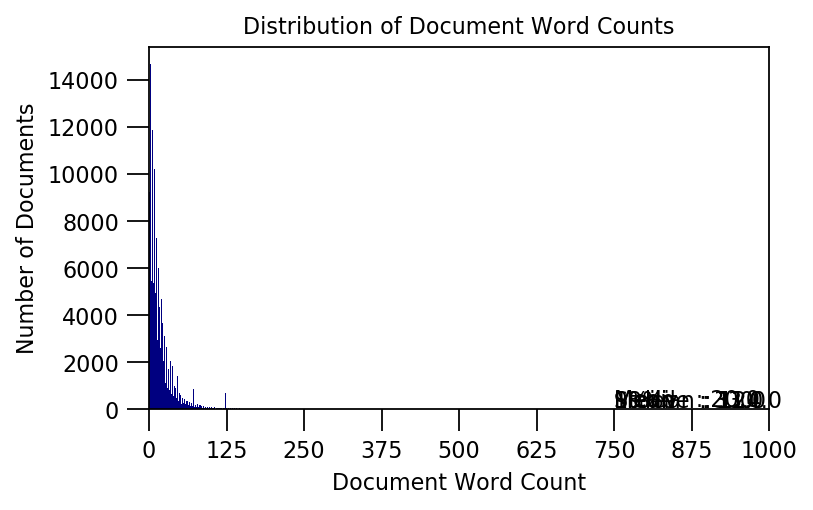

In [98]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(5,3), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=10)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=10))
plt.show()

### Count the number of documents belonging to each topic and their percentages

In [175]:
#get topic labels
topic_labels = df_dominant_topic_raw.Dominant_Topic.unique()
#list to collect document counts
doc_count_in_topics = []
doc_percentage = []
for label in topic_labels:
    #count number of docs belong to a label
    doc_count = df_dominant_topic_raw.Dominant_Topic.tolist().count(label)
    doc_count_in_topics.append(doc_count)
    doc_percentage.append(doc_count*100/len(df_dominant_topic_raw.Dominant_Topic))
    
pd.DataFrame({'Topic Number':[0,1,2,3,4,5,6,7,8,9], 'Num_of_Doc':doc_count_in_topics, 'Percentage':doc_percentage})

,Topic Number,Num_of_Doc,Percentage
0,0,79837,62.407761
1,1,3174,2.481083
2,2,8108,6.337940
3,3,4345,3.396442
4,4,3410,2.665562
5,5,11275,8.813551
6,6,5541,4.331343
7,7,6849,5.353793
8,8,3810,2.978238
9,9,1579,1.234288


**Over 60% of our documents fall under topic `0`. Goint by it's keywords, the topic addresses the basic creteria for applying for the PPR visa as well as mentioning the documents required from potential applicants to proof that they met these criteria. These are the most important issues discussants ask questions about and address in the social media platform from which the data was scraped.**

# Top Repesentative Words for Each Topic.

In [99]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

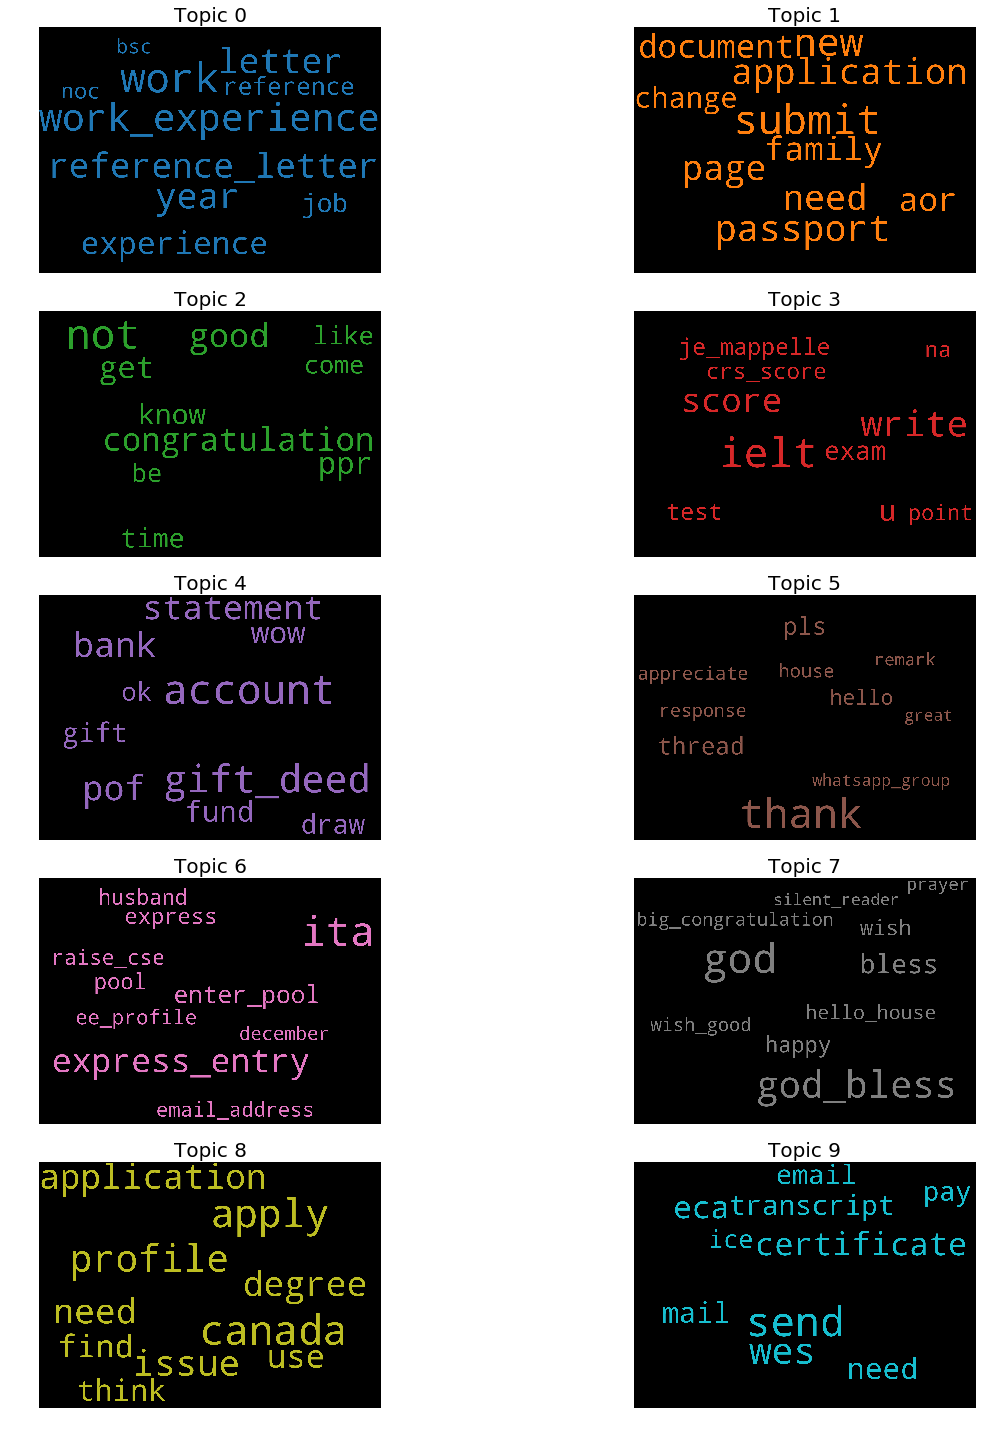

In [100]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='black',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=20))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# ===================== END OF NOTE ==========================